In this Kernel we'll beat the bookmakers by betting on some well-chosen tennis matches !  

All the data is from http://tennis-data.co.uk/data.php.  
We have all the tennis matches played in the ATP World Tour (Grand Slams, Masers, Master 1000 & ATP500) since January 2000, and until March 2018. 

There is much information in this dataset. This notebook will focus only on a quick analysis of the betting market, and propose a betting strategy that generates a non negligible return on investment. 

# Table of Contents
1. [Introduction : the data and some definitions](#introduction)
2. [Assessment of some basic strategies ](#basic)
    1. [Betting on all matches](#all_matches)
    2. [Betting on a selection of matches](#selection_matches)
3. [The proposed strategy](#proposed_strategy)
    1. [Confidence computation](#confidence)

# Introduction : the data and some definitions <a name="introduction"></a>

### Some important definitions : odds and ROI

Let's say you bet 10€ on Djokovic with an odd of 1.3

* If he wins, you go back home with your 10€, plus 3€ of benefits
* If he loses you go back home with 0€  
   
   
* If he wins, as you bet 10€ and won 13€, we say that your ROI (return on investment) is 30%
* If he looses, your ROI in -100%

### The tennis matches data 

In [36]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv("atp_data.csv")
data.Date = data.Date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

The dataset "atp_data.csv" is directly built from the data you can find on http://tennis-data.co.uk/data.php. I selected the columns that will be useful for the betting model. 

We have all the matches played on the ATP World Tour from January 2000 to March 2018.

One row per match. And we have some information about each match :

In [37]:
print("Total number of matches : "+str(len(data)))

Total number of matches : 50271


In [42]:
print(list(data.columns))

['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'Wsets', 'Lsets', 'Comment', 'PSW', 'PSL', 'B365W', 'B365L']


For each of the matches, you have the Tournament, Date, match winner, match loser,  surface, tournament round, the ATP rankings of the winner and the loser... These informations will be useful to build features for the model.

**And very important :** the odds of 2 bookmakers, Pinnacle and Bet365 (odds at the beginning of the match)

With this information we can estimate the ROI of any betting strategy.

Now let's begin by assessing the ROI of simple strategies...

# Assessment of some basic strategies <a name="basic"></a>

In [21]:
def basic_horizontal_barplot(values,labels,xaxis_label,title,xlim=None,figsize=None):
    """
    Please provide the labels corresponding to the values, the plot title, and the xaxis label.
    """
    # Possible colors to use - if not enough, colors are reused
    cs=["coral","tomato","peachpuff","orange","gold","firebrick","peru","khaki","chocolate"]
    cs=cs*(len(values)//len(cs)+1)
    # The figure
    if figsize==None:
        fig=plt.figure(figsize=(4,3))
    else:
        fig=plt.figure(figsize=figsize)
    ax = fig.add_axes([0,0,1,0.9])
    color=cs[:len(values)]
    ax.barh(range(len(values)),values,color=color)
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(labels)
    if xlim!=None:
        ax.set_xlim(xlim)
    plt.suptitle(title)
    ax.set_xlabel(xaxis_label)
    plt.show()

## Betting on all matches <a name="all_matches"></a>

Let's say we decide to bet on all matches between January 2011 and march 2018.

In [26]:
beg=datetime(2011,1,1) 
end=data.Date.iloc[-1]
indices=data[(data.Date>beg)&(data.Date<=end)].index
data_sel=data[["B365W","B365L","PSW","PSL","WRank","LRank"]]
data_sel=data.iloc[indices,:]
print("Number of matches during this period : "+str(len(data_sel)))

Number of matches during this period : 19012


*(with such a number of matches the confidence intervals will be very small)*

3 possible strategies are :
* always betting on the player with the smallest odd
* always betting on the player with the best ATP ranking
* betting completely at random for each match : "head or tail betting"

In the following graph we compare these 3 strategies for the 2 bookmakers.

**Precision :** we bet the same amount of money on each match.

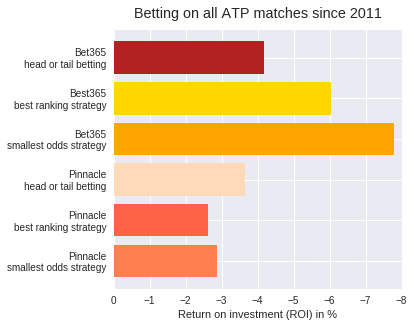

In [30]:
## Comparison of some basic strategies
roi_smallest_odd_ps=100*(data_sel.PSW[data_sel.PSW<data_sel.PSL].sum()-len(data_sel))/len(data_sel)
roi_best_ranking_ps=100*(data_sel.PSW[data_sel.WRank<data_sel.LRank].sum()-len(data_sel))/len(data_sel)
roi_random_ps=100*(data_sel.sample(int(len(data_sel)/2)).PSW.sum()-len(data_sel))/len(data_sel)
roi_smallest_odd_365=100*(data_sel.B365W[data_sel.B365W<data_sel.B365L].sum()-len(data_sel))/len(data_sel)
roi_best_ranking_365=100*(data_sel.B365W[data_sel.WRank<data_sel.LRank].sum()-len(data_sel))/len(data_sel)
roi_random_365=100*(data_sel.sample(int(len(data_sel)/2)).PSW.sum()-len(data_sel))/len(data_sel)
values=[roi_smallest_odd_ps,roi_best_ranking_ps,roi_random_ps,
        roi_smallest_odd_365,roi_best_ranking_365,roi_random_365]
labels=["Pinnacle\nsmallest odds strategy","Pinnacle\nbest ranking strategy","Pinnacle\nhead or tail betting",
       "Bet365\nsmallest odds strategy","Best365\nbest ranking strategy","Bet365\nhead or tail betting"]
xaxis_label="Return on investment (ROI) in %"
title="Betting on all ATP matches since 2011"
basic_horizontal_barplot(values,labels,xaxis_label,title,[0,-8],(4,4))

*(it means for example that if during 1000 matches we bet 1€ on the best ranked player on Pinnacle, we can expect to loose approximately 26€ in the end)*

Pinnacle has a reputation of having the best odds. It seems to deserve well its reputation. A global loss of ~2% is very low. On the contrary Bet365 seems to take a much higher commission than Pinnacle.


Considering the ROI of the random strategy, it is the best strategy on Bet365 and the worse on Pinnacle. One possible explanantion is that Bet365 is intended to more unexperienced gamblers. They might have noticed that their gamblers tend to overbet on the best ranked player, so to mitigate the risk they decrease the odds of the best ranked players. But we'll go back to these bookmakers techniques later...
  
  
**Now let's imagine we know in advance the result of each match. So we always bet on the winner of the match.**

What is the ROI we can expect ?

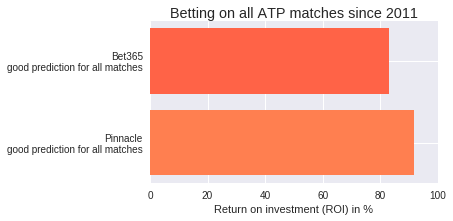

In [29]:
## Maximum possible ROI
max_roi_ps=100*(data_sel.PSW.sum()-len(data_sel))/len(data_sel)
max_roi_365=100*(data_sel.B365W.sum()-len(data_sel))/len(data_sel)
values=[max_roi_ps,max_roi_365]
labels=["Pinnacle\ngood prediction for all matches","Bet365\ngood prediction for all matches"]
xaxis_label="Return on investment (ROI) in %"
title="Betting on all ATP matches since 2011"
basic_horizontal_barplot(values,labels,xaxis_label,title,[0,100],(4,2.5))

Therefore if we bet on all matches we can't expect a ROI above 92%.

Once again it appears that Pinnacle is much more friendly than Bet365.

In the following we'll focus on Pinnacle only.

## Betting on a selection of matches <a name="selection_matches"></a>

**Idea :** instead of betting on all matches, we could focus on some matches where we are especially confident. 

In the following, every betting strategy will output a "confidence dataset". For each match it will contain the confidence in each player. From this dataset, we can set a threshold and bet only on the matches where our confidence is beyond a certain threshold.

As an example, we begin with a simple hypothetical strategy. We can say that our confidence is the odd itself. Therefore the greater the odd of a player the greater our will to bet on him. Let's imagine we know the winner of each match in advance and we bet only on the X% of players with the highest odds. This would be the perfect strategy in a world where we are omniscient.

What would be our ROI ?

In [44]:
def profitComputation(percentage_matchs,conf,model_name="0"):
    """
    Given a confidence dataset and a percentage of matches, computes the ROI 
    if we bet only on the percentage of matches we have the most confidence in
    (same amount for each match).
    """
    coeff=percentage_matchs/100
    lim=int(coeff*len(conf))
    conf=conf.sort_values("confidence"+model_name,ascending=False)
    conf=conf.iloc[:lim,:]
    profit=100*(conf.PSW[conf["win"+model_name]==1].sum()-len(conf))/len(conf)
    return profit

def plotProfits(conf,title=""):
    """
    Given a confidence dataset, plots the ROI according to the percentage of matches
    we bet on. 
    """
    profits=[]
    ticks=range(5,101)
    for i in ticks:
        p=profitComputation(i,conf)
        profits.append(p)
    plt.plot(ticks,profits)
    plt.xticks(range(0,101,5))
    plt.xlabel("% of matches we bet on")
    plt.ylabel("Return on investment (%)")
    plt.suptitle(title)
    plt.show()

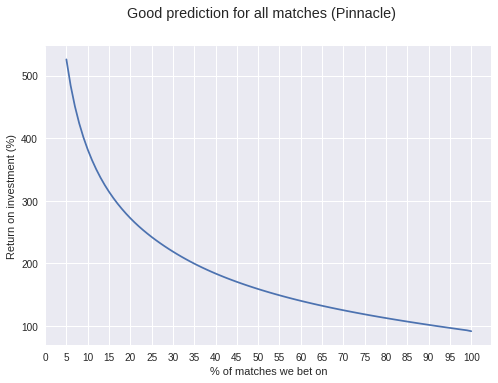

In [45]:
perfect_conf=pd.concat([data_sel[["Date","PSW","PSL"]]],1)
perfect_conf["win0"]=[1]*len(perfect_conf)
perfect_conf["confidence0"]=perfect_conf.PSW
perfect_conf=perfect_conf.rename(columns={"Date":"date"})
plotProfits(perfect_conf,"Good prediction for all matches (Pinnacle)")

As we can see if we bet on 100% of the matches, and we are right each time, we find again the ROI we found above (92%).

But if we bet only on the matches we are the most confident in (in our ideal case the match with the highest odds) our ROI is much higher.


Betting on a subset of matches is in general a good strategy. It is hard to get a good ROI by betting on ALL matches, but it is feasible with a subset. The only limit being the percentage of matches we bet on. If it is too small, the variance in our ROI will be big. 

# The proposed strategy <a name="proposed_strategy"></a>

XGBoost will predict a probability for each outcome of each match. 

Our confidence will be our probability divided by the probability implied by the bookmaker.

The probability implied by the bookmaker is the inverse of the odd.

**Example :** 

* There is an odd of 2.5 on the victory of Zverev against Nadal
* This odd tells us it is unlikely to happen
* More precisely the probability implied by the bookmaker is 1/2.5 = 0.4
* But our model tells us the real probability is 0.8, so Zverev is the favourite
* It might be because Nadal is overpriced (because he is Nadal)
* But we won't be fooled 
* Our confidence is here 0.8/0.4 = 2

## Confidence computation <a name="proposed_strategy"></a>

To test this betting strategy, we'll take time into account. 

We train a model to predict the outcome of each match given the last 10700. Out of the 10700, 300 are devoted to validation - the 300 consecutive matches right before the match we want to predict.

To make the process quicker, and as it doesn't harm the ROI, instead of training a new model to predict each match, we make the same model predict 2000 matches at a time.